In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
from matplotlib.patches import Ellipse, Rectangle
from matplotlib.lines import Line2D
import os
from tqdm import tqdm
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.convolution import Gaussian2DKernel

# Import images

In [2]:
def import_fits(path, name):
    sci = fits.open(os.path.join(path, name+"sci.fits"))
    wht = fits.open(os.path.join(path, name+"wht.fits"))
    image = sci[0].data
    image = image.byteswap().newbyteorder()
    weight = wht[0].data
    weight = weight.byteswap().newbyteorder()
    wcs = WCS(sci[0].header)
    return image, weight, wcs

def get_cutout(image, weight, wcs, position, size):
    cutout_image = Cutout2D(image, position, size, wcs=wcs)
    cutout_weight = Cutout2D(weight, position, size, wcs=wcs)
    image = np.ascontiguousarray(cutout_image.data)
    weight = np.ascontiguousarray(cutout_weight.data)
    rms = np.sqrt(1.0/weight)
    return image, weight, rms, cutout_image

In [3]:
base = "/home/max/Development/semester-project/data/"
#f105 = "hlsp_xdf_hst_wfc3ir-60mas_hudf_f105w_v1_"
f125 = "hlsp_xdf_hst_wfc3ir-60mas_hudf_f125w_v1_"
f140 = "hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_"
f160 = "hlsp_xdf_hst_wfc3ir-60mas_hudf_f160w_v1_"
f814 = "hlsp_xdf_hst_acswfc-60mas_hudf_f814w_v1_"
#sci_f105, wht_f105, wcs_f105 = import_fits(base, f105)
sci_f125, wht_f125, wcs_f125 = import_fits(base, f125)
sci_f140, wht_f140, wcs_f140 = import_fits(base, f140)
sci_f160, wht_f160, wcs_f160 = import_fits(base, f160)
sci_f814, wht_f814, wcs_f814 = import_fits(base, f814)

In [4]:
position = (3020, 3470)
size = (500, 500)
image_f125, weight_f125, rms_f125, cutout_f125 = get_cutout(sci_f125, wht_f125, wcs_f125, position, size)
image_f140, weight_f140, rms_f140, cutout_f140 = get_cutout(sci_f140, wht_f140, wcs_f140, position, size)
image_f160, weight_f160, rms_f160, cutout_f160 = get_cutout(sci_f160, wht_f160, wcs_f160, position, size)
image_f814, weight_f814, rms_f814, cutout_f814 = get_cutout(sci_f814, wht_f814, wcs_f814, position, size)

## Stack red bands

In [5]:
image_stacked = (np.multiply(image_f125, np.sqrt(weight_f125)) + \
                 np.multiply(image_f140, np.sqrt(weight_f140)) + \
                 np.multiply(image_f160, np.sqrt(weight_f160)))

In [6]:
rms_stacked = np.ones_like(image_stacked)

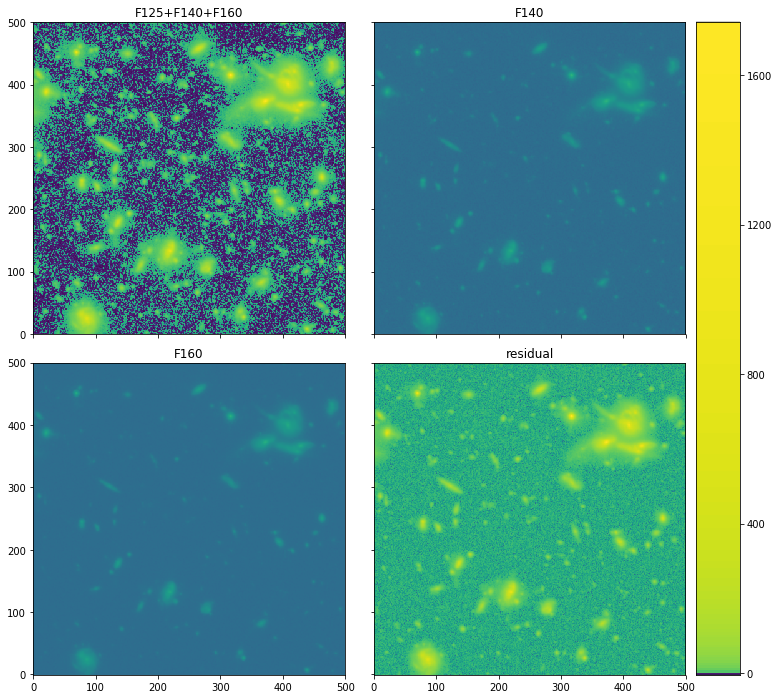

In [35]:
fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(2,2), axes_pad=0.4, share_all=True, cbar_location="right", \
                 cbar_mode="single", cbar_size="7%", cbar_pad=0.15)
images = [image_stacked, image_f140, image_f160, np.abs(image_stacked-image_f160)]
titles = ["F125+F140+F160", "F140", "F160", "residual"]
for (i,ax) in enumerate(grid):
    ax.set_title(titles[i])
    im = ax.imshow(images[i], interpolation='nearest', cmap='viridis', norm=SymLogNorm(linthresh=1e-2), vmin=image_stacked.min(), vmax=image_stacked.max(), origin='lower')
ax.cax.colorbar(im)
fig.savefig("images/stacked-bands.png", bbox_inches='tight')
fig.savefig("images/stacked-bands.pdf", bbox_inches='tight')

# Extract sources

In [9]:
kernel_cold = np.asarray(Gaussian2DKernel(1))
kernel_default = np.zeros((3,3))
kernel_default[1,1] = 1.0
kernel_default[[0,2],1] = 0.5
kernel_default[1,[0,2]] = 0.5
kernel_hot = np.zeros((3,3))
kernel_hot[1,1] = 1

modes = {
    'JH': {
        'hot': {
            'sigma': 1.5,
            'mincont': 1e-7,
            'nthresh': 64,
            'kernel': kernel_cold,
            'minarea': 5
        }
    },
    'H': {
        'hot': {
            'sigma': 1.5,
            'mincont': 1e-7,
            'nthresh': 64,
            'kernel': kernel_cold,
            'minarea': 5
        }
    }
}

bands = {
    'JH': {
        'image': image_stacked,
        'rms': rms_stacked
    },
    'H': {
        'image': image_f160,
        'rms': rms_f160
    }
}

In [10]:
import mmse

MMSE = mmse.MultiModeSourceExtractor(modes, bands)
MMSE.extract()

Starting multi mode source extraction on 2 bands
- running source extraction on JH band
	 + detected 264 sources in hot mode
- running source extraction on H band
	 + detected 164 sources in hot mode
Done! Detect 428 objects in total across all bands.


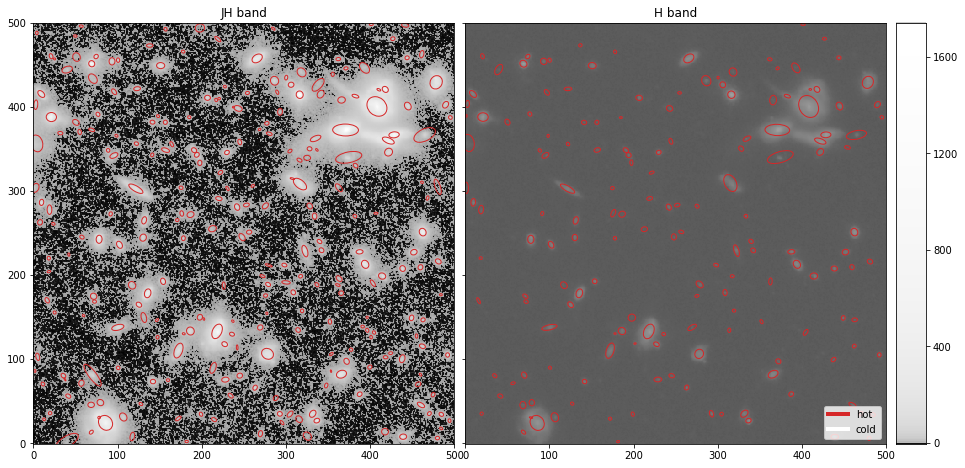

In [32]:
fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(1,2), axes_pad=0.15, share_all=True, cbar_location="right", \
                 cbar_mode="single", cbar_size="7%", cbar_pad=0.15)
images = [band['image'] for band in bands.values()]
bids = list(bands.keys())
for (i,ax) in enumerate(grid):
    ax.set_title(bids[i]+" band")
    im = ax.imshow(images[i], interpolation='nearest', cmap='gray', norm=SymLogNorm(linthresh=1e-2), vmin=image_stacked.min(), vmax=image_stacked.max(), origin='lower')
    for o in MMSE.catalog[MMSE.catalog['band'].str.match(bids[i])].itertuples():
        if o.mode == 'cold':
            ec = 'white'
        elif o.mode == 'hot':
            ec = 'C3'
        e = Ellipse(xy=(o.x, o.y), width=2*o.a, height=2*o.b, angle=o.theta*180.0/np.pi, edgecolor=ec, facecolor='none')
        ax.add_artist(e)
ax.cax.colorbar(im)
ax.cax.toggle_label(True)
lines = [Line2D([0], [0], color='C3', lw=4),
         Line2D([0], [0], color='white', lw=4)]
ax.legend(lines, ['hot', 'cold'], loc='lower right')
fig.savefig("images/Hstacked-I-detections.png", bbox_inches='tight')
fig.savefig("images/Hstacked-I-detections.pdf", bbox_inches='tight')

In [14]:
MMSE.find_similar('JH', 'hot', 'hot', band2='H', threshold=7)

In [15]:
MMSE.catalog.loc[MMSE.catalog['similar_to'].notnull() & MMSE.catalog['band'].str.match('H') & MMSE.catalog['mode'].str.match('hot'), ['x', 'y', 'a', 'b', 'theta', 'band', 'mode', 'similar_to']]

x           y          a         b  \
11e4d9fcf22e8997dfc309823f74e68d  181.583035    2.125962   1.740886  1.199562   
3076db0a0c996adeac237ea2f5bb8b0d  479.949944    6.037588   2.376892  2.275832   
c1689b1ed978dad166429de3a826b522  439.038730    7.796582   4.552222  3.031585   
144526025b8448098cc438c9b5956fea  172.165705   29.316243   1.891756  1.784724   
2f7eccc196d57f6f1637ab75ff7ee407   19.568204   35.362047   1.938837  1.914047   
2a347f1d41580d38f6e53459a2026412  484.498322   34.390886   2.907467  2.018366   
3fbb73b602bbb85cec8fde0da355c061  199.103633   34.740086   2.574241  1.895723   
723aca96533da49bf59988510a1a5e34  304.638754   34.735915   2.263076  2.120355   
fe959da92f6cf06565dc7dfb987db3b1  292.685963   35.249387   4.091602  2.327562   
99db9aa0f8a1e26fbdcc079246045ccb  127.156295   47.219447   2.108264  1.693745   
d56ada85c8694bd2a815eaad19260937  336.623245   27.073195   3.292061  2.622159   
645528db2c5903bb74f27c59d0a98d08  331.752683   35.263705   5.030094  3.386331   
6855fa48236c6e6bdb6c0200e0c8b3ea  470.342181   35.496215   2.574336  2.059042   
0d378d6c27343329e73f4a315a24a0c6  460.123854   45.701171   4.747110  2.299254   
f9fd01c4421f4cc0259f7c269368e07f   41.775524   56.259592   3.158498  2.297519   
6c3d8716b0da7c87ad5de20f4f493e57   85.561111   24.305777   9.326881  7.953426   
c626395e099c369ae2420584923c76dd   78.198591   30.598933   2.021533  0.838134   
364dff4b4032e0be7cc35dd19ca6c3ab   69.330279   13.330317   3.051638  1.773788   
6e6171109139f9397c73bd20f52ed081  106.539911   31.024899   5.520054  4.338976   
85c3a87f61d449147a01ac5d76ff67b9   68.615597   45.422698   4.350599  3.598384   
4b428ad5e5cf471354c7a7c224e15553   79.136371   48.322762   3.741255  3.196154   
55a7339b6fb12967deb27e12b5bce1f9  387.346455   58.485371   3.032644  2.576930   
fed56a7103a06dbe71d6e01330191c87  263.126240   66.399792   2.955954  2.443870   
f69cb1ef46481f3b5af07ad757a0807d  141.850662   73.499239   2.748700  2.524296   
75119a71b6ca5230a28fd1c5a3a5a2fe   35.184319   80.364291   2.888843  2.044761   
d9343312ed6e6c7266d5bb718955de6d  100.802645   89.862537   1.901049  1.656661   
15ecc79ae15b9ea0c350f80c0188c954  365.838733   82.191077   6.248309  4.116022   
ae11d79e9ffa06dce35fa99dbee1fc30  372.127838   97.495684   3.196599  2.812844   
0f2c5ca5f8afd4ae7c1d84c7daf6211a  492.008578  105.126880   2.523395  2.132369   
93761d3845ecb97fbf16137fb7bef27a  462.225959  115.634527   2.423325  2.135551   
...                                      ...         ...        ...       ...   
59b6e7a4b0e81eebeb5b73de9eca17e9   50.293037  381.731862   3.740790  2.744682   
430326aa225e6f9d35e09219521c12e5  371.148581  445.578662   2.034517  1.632126   
22ee2d69aaec671be65eb535903301a6  361.853528  456.265764   2.687272  1.870495   
5472542174e154d7397bff8c9a38d245  150.950641  448.793494   4.681607  3.697209   
9f63887f7eedd1b34fc24358e921520f  443.991486  458.034234   2.535678  2.282010   
7cd7210d38b17a9b1c996fa4635b6f71   20.601933  459.886206   3.148202  2.165241   
ffeb7c99f05c2e6b75c68758025a083b  178.130439  465.084871   2.211415  1.752047   
1f75ce0bc8a9aa166e23e33da952a45e   69.226475  451.039626   4.434772  3.866255   
f4a7559b8c0704192b4b428dddef1972   74.403840  459.604867   2.868268  2.246241   
cdf2b4c97547f027a8cbcac00648d75f   93.374539  453.859321   3.879506  3.685949   
351b164136dbb303fd23f2a5f53c1183  100.361441  455.259727   2.523038  1.968564   
16c0d26fd9ada3ca51335019560c8e11   39.867391  444.124585   6.777238  3.866329   
5d5c81c7fcfe8d1760354c67bfefdd73  136.864523  472.934981   2.052277  1.803744   
597b825fff8b0683f01a5ca58dd8094b  426.882380  480.762939   2.285363  1.694372   
66af97cb8a05880b464a2861ef2590e6  421.869666  359.113957   7.120680  2.933477   
0f38f362ab6e4cd4ab30344cb9ed8a68  428.521705  366.570084   6.028291  3.429383   
d9ec199238fc6ff3199b56724ef604b6  410.000887  420.496797   1.565736  1.031693   
78a1b6fefb07ea5d82223fb21c3fdfca  417.944110  420.541563   3.787147  3.135

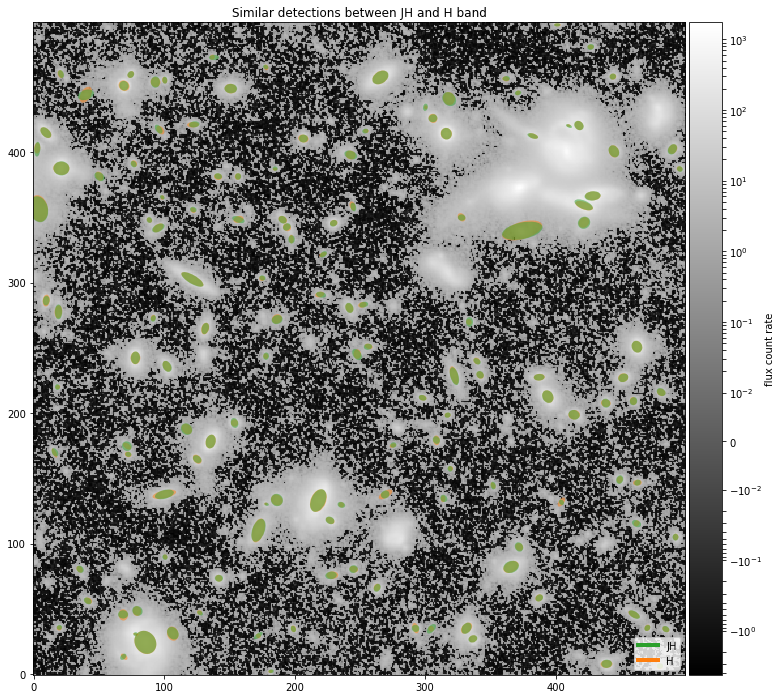

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image_stacked, interpolation='nearest', cmap='gray', norm=SymLogNorm(linthresh=1e-2), origin='lower')
for o in MMSE.catalog[MMSE.catalog['similar_to'].notnull() & MMSE.catalog['band'].str.match('H') & MMSE.catalog['mode'].str.match('hot')].itertuples():
    e = Ellipse(xy=(o.x, o.y), width=2*o.a, height=2*o.b, angle=o.theta*180.0/np.pi, edgecolor='none', facecolor='C1', alpha=0.5)
    ax.add_artist(e)
    s = MMSE.catalog.loc[o.similar_to]
    f = Ellipse(xy=(s.x, s.y), width=2*s.a, height=2*s.b, angle=s.theta*180.0/np.pi, edgecolor='none', facecolor='C2', alpha=0.5)
    ax.add_artist(f)
ax.set_title("Similar detections between JH and H band")
fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")
lines = [Line2D([0], [0], color='C2', lw=4),
         Line2D([0], [0], color='C1', lw=4)]
ax.legend(lines, ['JH', 'H'], loc='lower right')

Keep all the sources, but those in the H band that are similar to sources in the JH band

In [17]:
similar_h = MMSE.catalog[MMSE.catalog['similar_to'].notnull() & MMSE.catalog['band'].str.match('H') & MMSE.catalog['mode'].str.match('hot')]
MMSE.discard(similar_h.index)

In [18]:
hot_jh = MMSE.catalog[MMSE.catalog['band'].str.match('JH') & MMSE.catalog['mode'].str.match('hot')]
MMSE.keep(hot_jh.index)

In [19]:
hot_h = MMSE.catalog[MMSE.catalog['similar_to'].isnull() & MMSE.catalog['band'].str.match('H') & MMSE.catalog['mode'].str.match('hot')]
MMSE.keep(hot_h.index)

In [20]:
positions = MMSE.catalog.loc[MMSE.catalog['keep']==True, ('x', 'y')]
positions

x           y
ed2784a7ead6b5292f75966c8975f0c3  181.978542    2.216550
2f2e122dcee068902250ab6d2f715398  479.893405    6.304054
471c7c4208cc1ef161a41f229b61bea7  269.647580   11.532521
b8aea6feca4796ea82d311752a476df2  484.231272   17.742773
69877eb6a11739ab8205ca6806558576  439.175003    7.952314
f71256c78b07ccb7716f3cb4d7a854cf  417.635506   13.901746
23762a5ea6f7dc3d2e6c9f424ab67b7a  214.549318   28.253551
c1efe990f582a586951f8d1b2d1c2498   12.585683   28.594706
922bcaf8c0bd4f4deb1c970d6f2b5c58   19.732393   35.891315
e641f43348066f8454aaee07a0ce9549  199.000792   34.623891
f175d201e6e35adaab09ca0dd6b39acd  172.081250   29.552095
6703d256a819662d38bf0b1945d404b4  127.563480   46.798617
4cc7ebb62a892186b0916083dcb4c58c  336.624808   27.042292
d460d883f5c9b4ea1aece241da78e03d  331.715737   35.186898
80ee64851904320b990dff8d3299ecdf  295.223214   24.680481
6486061683c9e42e05c78202405be80b  292.672750   35.077357
bd162227b0913f86347ba13cea1b059e  325.334870    8.575294
940a602033a29ba5760e52d459471274  315.564544   28.726009
983d93e335c2477fa9c8e10030e5dd9f  304.783392   34.793026
bd7d43711ec65d416019e40d66a74147  470.331359   35.418585
d2714870c50f273a6b3c583dddf7e9ad  460.328378   45.639346
daa3a581ec308036b94867e956a35669  494.233456   26.983545
eb622b5ad648e79f73597b1a8a193c6d  484.506310   34.501373
ec0bf7088a95a91dbae64f78637e2d4a  474.701282   57.884416
abc486e6475862c2f0f7080f582e8c62  287.728483   53.902114
bdec78b14ba721335de2f6c971e626ac   41.344504   56.159398
270b2ef77bef922acf9e80bfaf440050  234.209025   56.667806
a2e8ffed48ccb810bfbf84b801f8a079  387.493306   58.416106
1333a6373bf315966018acd719b950bf   11.225833   70.495354
1601c9dacff004601264e6cf82b70f68  457.018368   70.195329
...                                      ...         ...
f78b677161628ccff615be795b3608d3  156.875569  491.981775
ecb2ff196095559d566af3022357c55b  284.895344  492.693775
5a786f4d7b0854053e8c9a80b73738ec   56.743825  495.591570
8a48124ccd2bd34a77317717ea70f4b1  197.688631  493.536303
8be0304e624a3d4aa8c8de2f87f81a37  401.251729  497.669088
3f0e156351a668830650c038ec2db48e  441.494931  496.699436
fb97f43411991ea9384fc5d7611ab6a5   56.854397   71.447704
da40f0b4bfc6f50c614a7a7fbe5677ec   70.154611   81.078511
eb40e788bb840937903fd1178e81c79d  437.644467   99.547692
8ca823d7f9a6572e08aaec820005c1bc  278.025548  106.364131
a3747e99fadd7f12123b1859c89941af  201.791129  118.602916
38581e70022fff6692ab1f80a7847760  197.989749  149.402817
7852ca67c1e2f44d16e6aa7c1417dd90  362.711534  192.374260
461bb74e21ab092ea7808840fcf966aa  278.605401  188.843749
8cefb98f6a48e6c5834124f40662987b  212.892385  254.431424
1fdc182dadfc55a90201991e4c76c72f  130.282051  244.543172
d631b5137b7655b0127c6ed442505556  175.931607  273.448443
50430513d70fa54b69ce43ed3337810d  275.541254  281.807729
a03769eb556ad5612e6f5e4d1524aee7    1.491571  303.519649
fe3e67a7756bdf1d84248c0ddefe627c    1.495370  388.997007
a7fd237c75c5d6d05ec58e812790fdb0  408.035611  400.242409
052e03aff60a58db3cecdb8be6553712  370.840092  372.354263
bb4f96a467d55f18113396b31d9ce4cf  334.844772  362.011252
ef2a57133ca1df5a4abe9427406e2810  365.818183  407.844351
c5879b10c1f53e45baca6446733ff81a  454.200261  351.606191
9be3204410b5c0fbba7dba43de9df29d  464.830092  366.472583
b69db8ff7dbec1c059453c6c66e04b09  286.407515  430.848246
1857b7655dc826beca46ee21ee011620  315.072514  309.275093
9db69b97944392aaefd5627ea41ae072  478.383934  428.908697
cd5493bfb2f43e5bf8450cfdd1bfc12d  392.949468  446.109358

[288 rows x 2 columns]

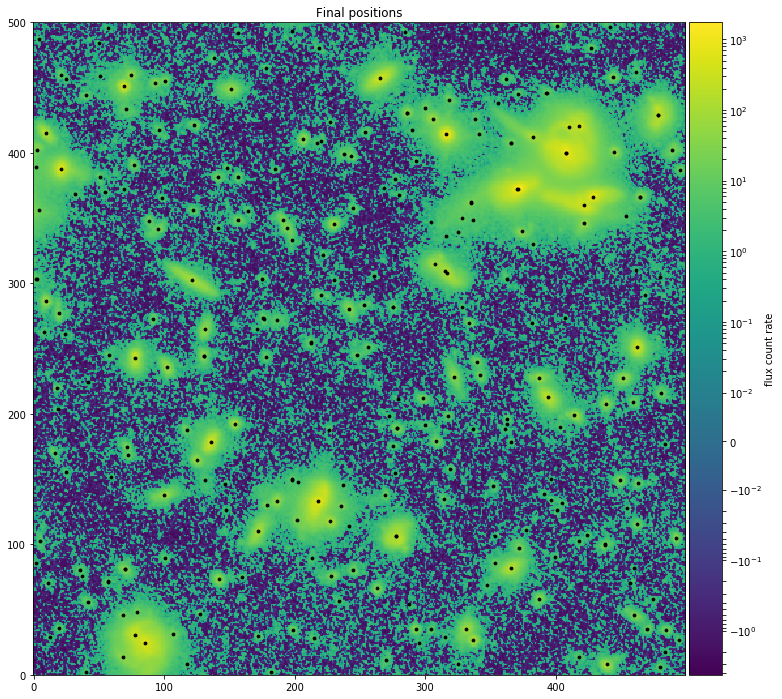

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image_stacked, interpolation='nearest', cmap='viridis', norm=SymLogNorm(linthresh=1e-2), origin='lower')
ax.scatter(positions['x'], positions['y'], s=8, edgecolor='black', facecolor='black')
ax.set_title("Final positions")
ax.set_ylim((0, 500))
fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")
fig.savefig("images/Hstacked-final-positions.png", bbox_inches='tight')
fig.savefig("images/Hstacked-final-positions.pdf", bbox_inches='tight')

In [25]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1

In [26]:
Bouwens_Cat = Vizier.get_catalogs(catalog="J/ApJ/803/34")[0]

In [27]:
bouw = SkyCoord(ra=Bouwens_Cat['RAJ2000'], dec=Bouwens_Cat['DEJ2000'], unit=(u.hourangle, u.deg))
# origin: coordinate in the upper left corner of the image, for Numpy should be 0
xp, yp = bouw.to_pixel(wcs_f160, origin=0)
bouw_original = zip(xp, yp)

In [28]:
bouw_cutout = np.zeros((len(xp),2))
for (i,t) in enumerate(bouw_original):
    bouw_cutout[i,:] = cutout_f160.to_cutout_position(t)

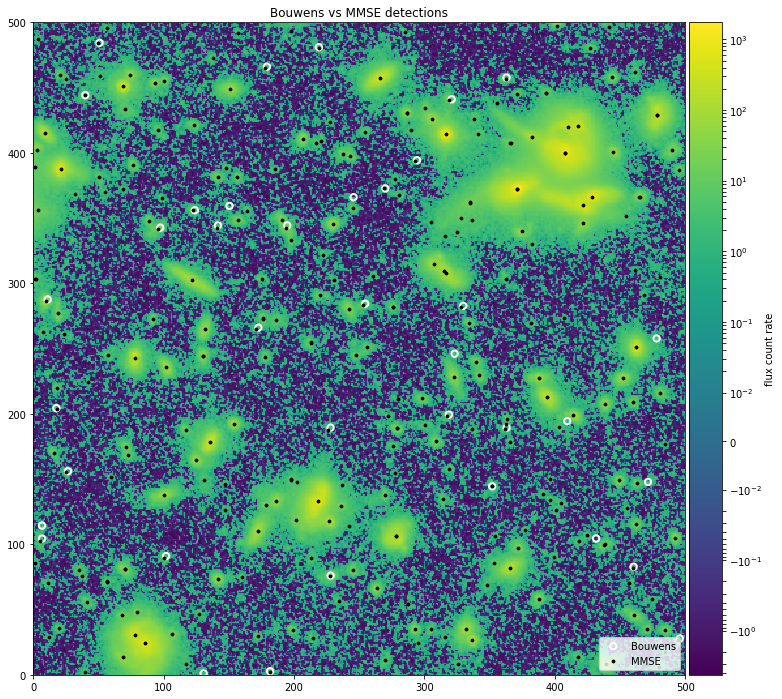

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image_stacked, interpolation='nearest', cmap='viridis', norm=SymLogNorm(linthresh=1e-2), origin='lower')
ax.scatter(bouw_cutout[:,0], bouw_cutout[:,1], s=40, linewidths=2, edgecolor='white', facecolor='none', label="Bouwens")
ax.scatter(positions['x'], positions['y'], s=8, edgecolor='black', facecolor='black', label="MMSE")
ax.set_ylim((0, 500))
ax.set_xlim((0, 500))
ax.set_title("Bouwens vs MMSE detections")
ax.legend(loc='lower right')
fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")
fig.savefig("images/Hstacked-bouwens-mmse.png", bbox_inches='tight')
fig.savefig("images/Hstacked-bouwens-mmse.pdf", bbox_inches='tight')

In [33]:
def detection_fraction(catalog, positions, threshold=5):
    detected = 0
    for i in range(catalog.shape[0]):
        xi, yi = catalog[i,:]
        ds = [np.linalg.norm(catalog[i,:]-positions[j,:]) for j in range(positions.shape[0])]
        md = np.min(ds)
        if md < threshold:
            detected += 1
    return detected/catalog.shape[0]

In [34]:
indx = np.logical_and(bouw_cutout[:,0]>=0, bouw_cutout[:,0]<=500)
indy = np.logical_and(bouw_cutout[:,1]>=0, bouw_cutout[:,1]<=500)
ind = np.logical_and(indx, indy)
df = detection_fraction(bouw_cutout[ind,:], positions.as_matrix())
print("Fraction of detected sources in Bouwens catalog: {:.2f}".format(df))

Fraction of detected sources in Bouwens catalog: 0.76
